In [14]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import split
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import cross_validate
from sklearn import metrics
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# implementing user based collaborative filtering under SVD
# read in ratings.txt and documents.txt into pandas

# ratings dataframe
rating_raw = pd.read_csv('fairgrecs-dataset/ratings.txt', sep = '\t', header = [0])

rating_raw = rating_raw.truncate(50, 50000) #matching with other datasets

# user features dataframe (features of keyword)
doc_raw = pd.read_csv('fairgrecs-dataset/documents.txt', sep = '\t', header = [0])



# passing in users and items
users = rating_raw['USER_ID'].values.flatten()
items = rating_raw['DOCUMENT_ID'].values.flatten()
ratings = rating_raw['RATE'].values.flatten()

# passing in user features 
feature_name = doc_raw['{KEYWORDS}'].values.flatten()
feature_value = doc_raw['DOCUMENT_ID'].values.flatten()

In [7]:
reader = Reader(rating_scale = (1,5))

data = Dataset.load_from_df(rating_raw[['USER_ID', 'DOCUMENT_ID', 'RATE']], reader)




In [8]:
trainset, testset = split.train_test_split(data, test_size=0.25)

In [5]:
# print user counts in train_set

print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  333 

Number of items:  16890 



In [24]:
rmse_scores = []
AUC_scores = []

total_epochs = 30

for epoch in range(total_epochs): #takes a while to run
    #train model
    algo = SVD(n_epochs = epoch, lr_all = 0.01)
    algo.fit(trainset)
    
    #test model
    predictions = algo.test(testset)
    
    #cross validate

    results = cross_validate(
        algo = algo, data = data, measures=['RMSE'], 
        cv=5, return_train_measures=True
        )
    
    #get actual (index 2 of predictions) and estimates (index 3 of predictions)

    actual  = []
    predicts = []

    for i in range(len(predictions)):
        actual.append(predictions[i][2])
        predicts.append(predictions[i][3])

    fpr, tpr, thresholds = metrics.roc_curve(actual, predicts, pos_label=2)
    AUC_scores.append(metrics.auc(fpr, tpr))

    rmse_scores.append(results['test_rmse'].mean())


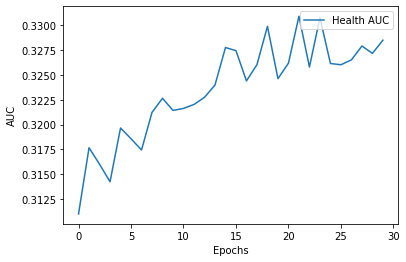

In [30]:

# Graph
x = np.arange(total_epochs)

plt.plot(x, np.array(AUC_scores))
plt.xlabel('Epochs')
plt.ylabel('AUC')

plt.legend(['Health AUC'], loc = 'upper right')

plt.savefig('CF_Model_SVD_Health.png', facecolor = 'w')
